# Functionality of this notebook: 

* calculate the ciCOH for normal and mild LFP data in reach phase [reachonset touch]

* skb is short for single kluverboard 

## Import Packages

In [1]:
import os, sys
import scipy.io as sio
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle 
%matplotlib inline

In [2]:
# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)

# import_nbmodule used for import package in .ipynb
import import_nbmodule

# import util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

# import ciCoherence_overtime in connAnalyTool/synchronization_indices.ipynb
from connAnalyTool.synchronization_indices import ciCoherence_acrosstrials
from connAnalyTool.synchronization_indices import ciCoherence_overtime

importing Jupyter notebook from /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb
importing Jupyter notebook from /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb


## exp subfolders & code_corresfolder

In [3]:
_, _, pipelinefolder, _= exp_subfolders()

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

# corresfolder
corresfolder = code_corresfolder(os.getcwd(), nb_name)

## global parameters

In [17]:
eventphase = 'reach'

freq = [25, 30]

animal = 'Pinky'

In [ ]:
load_epochfolder = os.path.join(pipelinefolder, 'NHP_Pinky', 
                                '1_dataAnaly/0_spectralAnaly/epochs_filtered_Pinky_1/out')

In [19]:
coli_target, coli_reachonset, coli_touch, coli_returnonset, coli_mouth = 0, 1, 2, 3, 4


if eventphase == 'reach':
    cols = [coli_reachonset, coli_touch]
    
elif eventphase == 'return':
    cols = [coli_returnonset, coli_mouth]

## save file setup

In [20]:
savefolder = corresfolder
savefilename =  'ciCOH_' + eventphase + '_freq' + str(freq[0]) + '_' + str(freq[1]) +'.pickle'
savefile_ciCOH = os.path.join(savefolder, savefilename)

## ciCOH sub-functions

###  ciCOH_lfp() <a id='funcciCOH_lfp'></a>

* calculate ciCOH of each pair of channels in reach phase from lfp data

* only analyze the reach phase whose duration is longer than 500ms and shorter than 1s

In [21]:
def calciCOH_lfp(lfp, fs, idxevent, idxevent_varNames, cols, tdur_min = 0.5, tdur_max = 1):
    
    """
        return the ciCOH in the reach phase for all the trials extracted from lfp data
        
        Args:
        
            lfp: local field potential data (nchns * ntemporals * ntrials)
            
            fs: sample rate
            
            idxevent: event indices array (ntrials *5)
            
            idxevent_varNames: event names array ['TargetTime' 'ReachTimeix' 'TouchTimeix' 'ReturnTimeix' 'MouthTimeix']
            
            cols: column indices for reach phase
            
            tdur_min, tdur_max: minimal and maximal duration for reach phase
            
        Return:
            ciCOH_alltrials: ciCOH values for all trials extracted from lfp data (nchns * nchns * ntrials)
    """




    ###################################################
    #
    #    extract lfp data of reach phase for each trial
    #
    ###################################################

    # idxdur_min, idxdur_max
    idxdur_min, idxdur_max = int(np.round(tdur_min * fs)), int(np.round(tdur_max * fs))

    nchns,_ ,ntrials = lfp.shape
    
    # initial ciCOH_alltrials array for all trials
    ciCOH_alltrials = np.zeros((nchns, nchns, ntrials))

    for triali in range(ntrials):

        ### extract the extract lfp data of reach phase for each trial, only extract that last longer than 500ms ###

        # start and end indices over time of specific phase for triali 
        idxtime_str, idxtime_end = int(idxevent[triali, cols[0]]), int(idxevent[triali, cols[1]])

        # remove trials of reach phase longer than tdur_max and shorter than tdur_min
        if idxtime_end - idxtime_str < idxdur_min or idxtime_end - idxtime_str > idxdur_max:
            continue;

        # extract lfp data in specific phase of one trial (n_chns * n_times)
        lfp_1trial = lfp[:, idxtime_str:idxtime_end, triali]


        ### calculate ciCOH between each pair of channels ###

        for chni in range(nchns-1):

            # signal of channel chni
            signal1 = lfp_1trial[chni, :]

            for chnj in range(chni+1, nchns):

                # signal of channel chnij
                signal2 = lfp_1trial[chnj, :]

                # ciCOH_alltrials assignment
                ciCOH_alltrials[chni, chnj, triali] =  ciCoherence_overtime(signal1, signal2)
                
                # symmetrical
                ciCOH_alltrials[chnj, chni, triali] = ciCOH_alltrials[chni, chnj, triali]

                del signal2
            del signal1

        del idxtime_str, idxtime_end, lfp_1trial


    # return
    return ciCOH_alltrials

### ciCOH_1file() <a id = 'func_ciCOH1file'></a>
* calculate ciCOH of each pair of channels in reach phase for one file

* call the function [ciCOH_lfp](#funcciCOH_lfp)

In [22]:
def calciCOH_1file(file, cols):
    
    """
        ciCOH values for 1 file
        
        Args:
        
        file: file name 
        
        cols: column indices
        
        Returns:
        
            ciCOH1file: 
                
                alpha band corrected imaginary coherence value of all pairs of channels for all trials in file 
                (nchns * nchns * ntrials)
    """
    

    ######################################
    #
    #    extract data of lfp, idxevent, fs
    #
    ######################################
    
    # load the stk trial data in alpha band with idxevent, idxevent_varNames, fs
    matdat = sio.loadmat(file, variable_names = ['lfptrial_fre', 'idxevent', 'idxevent_varNames', 'fs'], 
                         struct_as_record = False, squeeze_me = True)

    # fs: sample rate
    fs = matdat['fs'] 

    # idxevent (n_trials * 5): indices for targetonset, reachonset, reach, return and mouth
    idxevent, idxevent_varNames = matdat['idxevent'], matdat['idxevent_varNames']
        
    # lfp
    lfp = matdat['lfptrial_fre']
    
    # ciCOH values of alpha band in the reach phase for 1 file
    ciCOH_1file = calciCOH_lfp(lfp, fs, idxevent, idxevent_varNames, cols = cols, tdur_min = 0.5, tdur_max = 1)
        
        
    # return
    return ciCOH_1file

### ciCOH_allfiles

1. return a ciCOH dictionary result containing concatenated ciCOH values from all normal and mild files individually
   in alpha band

2. call function [ciCOH_1file(file)](#func_ciCOH1file)

In [23]:
def calciCOH_allfiles(files, cols):
    
    """
        return a ciCOH dictionary result containing concatenated ciCOH values from all normal and mild files individually 
        
        
        Return:
            dic_ciCOH: a ciCOH dictionary result 
                       dic_ciCOH.keys() = ['ciCOH_alpha_normal', 'ciCOH_alpha_mild']
    """
    
    

    # delete ciCOH_alpha_normal if exist inside this function
    if 'ciCOH_normal' in locals():
        del ciCOH_normal
        
    # delete ciCOH_alpha_mild if exist inside this function
    if 'ciCOH_mild' in locals():
        del ciCOH_mild
        
    # concatenate ciCOH values from all files
    for file in files:
        
        print("dealing " + file)

        # ciCOH value of all pairs of channels for all trials in one file (nchns * nchns * ntrials)
        ciCOH_1file = calciCOH_1file(file, cols)

        # normal case
        if 'normal' in file and 'mild' not in file:
            
            # alpha normal
            if 'ciCOH_normal' not in locals():
                # first normal file
                ciCOH_normal = ciCOH_1file
            else:
                # append normal file
                ciCOH_normal = np.concatenate((ciCOH_normal, ciCOH_1file), axis=2)


        # mild case
        if 'mild' in file and 'normal' not in file:
            
            # alpha mild
            if 'ciCOH_mild' not in locals():
                # first mild file
                ciCOH_mild = ciCOH_1file
            else:
                # append mild file
                ciCOH_mild = np.concatenate((ciCOH_mild, ciCOH_1file), axis=2)


        del ciCOH_1file
        
    
    # create ciCOH results dictionary
    dic_ciCOH = {"ciCOH_normal": ciCOH_normal, "ciCOH_mild": ciCOH_mild} 
    
    return dic_ciCOH

## outer loop

In [24]:
## glob all .mat files (both mild and normal files)
files = glob.glob(os.path.join(load_epochfolder, 'freq[' + str(freq[0]) + ' ' + str(freq[1]) + '*.mat'))


##  a ciCOH dictionary containing concatenated ciCOH values from all normal and mild files 
# individually in alpha band
print("calculating ciCOH values for normal and mild individually.....")
dic_ciCOH = calciCOH_allfiles(files, cols = cols)


## save dic_ciCOH
pickle.dump(dic_ciCOH, open(savefile_ciCOH, "wb" ) )

calculating ciCOH values for normal and mild individually.....
dealing /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/0_spectralAnaly/epochs_filtered_Pinky_1/out/freq[25 30]Pinky_lfptrial_mild_102417_bktdt3.mat
dealing /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/0_spectralAnaly/epochs_filtered_Pinky_1/out/freq[25 30]Pinky_lfptrial_normal_012417_bktdt2.mat
dealing /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/0_spectralAnaly/epochs_filtered_Pinky_1/out/freq[25 30]Pinky_lfptrial_normal_012717_bktdt7.mat
dealing /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/0_spectralAnaly/epochs_filtered_Pinky_1/out/freq[25 30]Pinky_lfptrial_normal_012617_bktdt2.mat
dealing /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/0_spectralAnaly/epochs_filtered_Pinky_1

## plot section

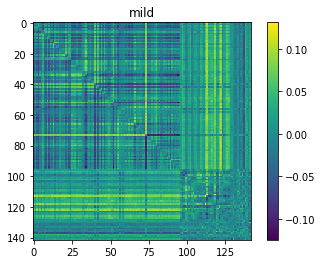

In [25]:
plt.imshow(np.mean(dic_ciCOH['ciCOH_mild'], axis = 2));
plt.colorbar()
plt.title('mild')
plt.show()

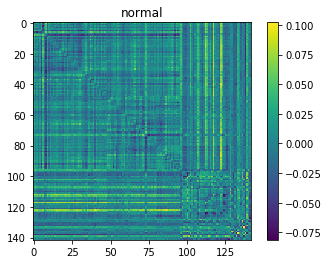

In [26]:
plt.imshow(np.mean(dic_ciCOH['ciCOH_normal'], axis = 2))
plt.title('normal')
plt.colorbar()
plt.show()